In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

input_file_name = 'blinkit_cleaned_data_for_ml.csv'

df_cleaned = pd.read_csv(input_file_name)


print("Cleaned DataFrame successfully loaded for Phase 2:")
print(df_cleaned.head())

# 1. Prepare data for modeling
X = df_cleaned.drop([
    'Item Identifier', 
    'Outlet Identifier', 
    'Item Visibility'  
], axis=1)

y = X['Sales_Log']
X = X.drop('Sales_Log', axis=1)


# 2. Convert all categorical features to numerical using One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Train an advanced regression model (XGBoost)
print("\nTraining XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=5, 
    n_jobs=-1, 
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 4. Evaluate the model
predictions = xgb_model.predict(X_test)

# Calculate RMSE and R-squared. 
# CRITICAL: We converted the log-transformed values back to the original scale for the RMSE!
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(predictions)))
r2 = xgb_model.score(X_test, y_test)

print("\n--- Model Evaluation (Target: Sales) ---")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")




Cleaned DataFrame successfully loaded for Phase 2:
  Item Fat Content Item Identifier              Item Type Outlet Identifier  \
0          Regular           FDX32  Fruits and Vegetables            OUT049   
1          Low Fat           NCB42     Health and Hygiene            OUT018   
2          Regular           FDR28           Frozen Foods            OUT046   
3          Regular           FDL50                 Canned            OUT013   
4          Low Fat           DRI25            Soft Drinks            OUT045   

  Outlet Location Type Outlet Size        Outlet Type  Item Visibility  \
0               Tier 1      Medium  Supermarket Type1         0.100014   
1               Tier 3      Medium  Supermarket Type2         0.008596   
2               Tier 1       Small  Supermarket Type1         0.025896   
3               Tier 3        High  Supermarket Type1         0.042278   
4               Tier 2       Small  Supermarket Type1         0.033970   

   Item Weight  Rating  Outle


--- Corrected Top 10 Sales Drivers (Feature Importance) ---
Item Type_Seafood                  0.081007
Item Type_Breads                   0.072106
Item Type_Household                0.055732
Item Type_Soft Drinks              0.053271
Item Fat Content_Regular           0.051378
Item Type_Fruits and Vegetables    0.050824
Item Weight                        0.048954
Item Type_Dairy                    0.045842
Item Type_Starchy Foods            0.045780
Item Type_Frozen Foods             0.043228


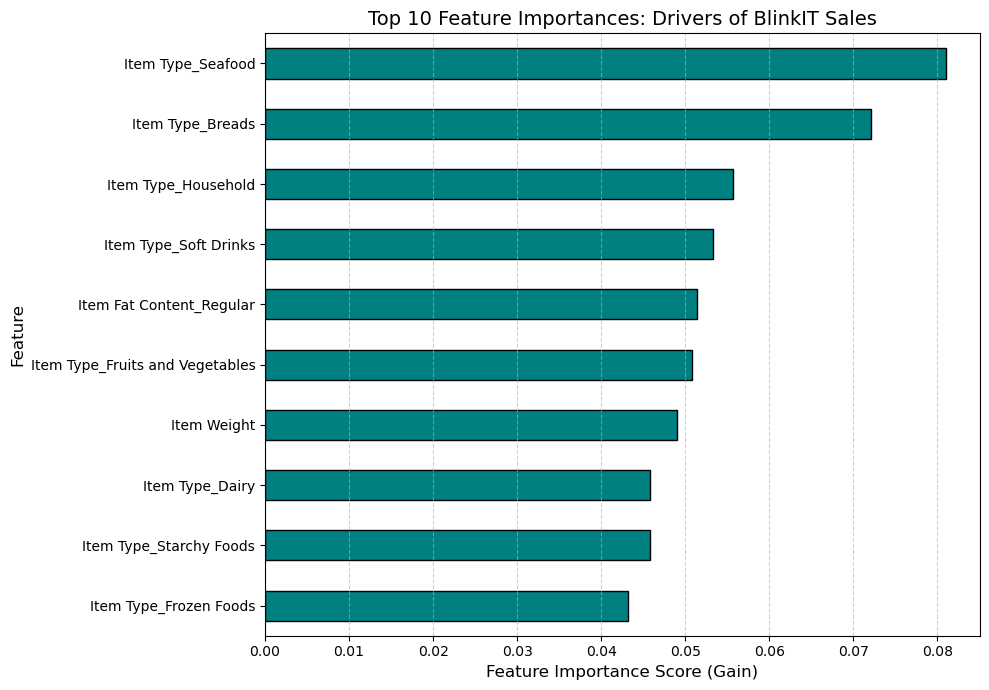

In [14]:
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

print("\n--- Corrected Top 10 Sales Drivers (Feature Importance) ---")
print(top_10_features.to_string())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
top_10_features.sort_values(ascending=True).plot(
    kind='barh', 
    color='teal',
    edgecolor='black'
)
plt.title('Top 10 Feature Importances: Drivers of BlinkIT Sales', fontsize=14)
plt.xlabel('Feature Importance Score (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

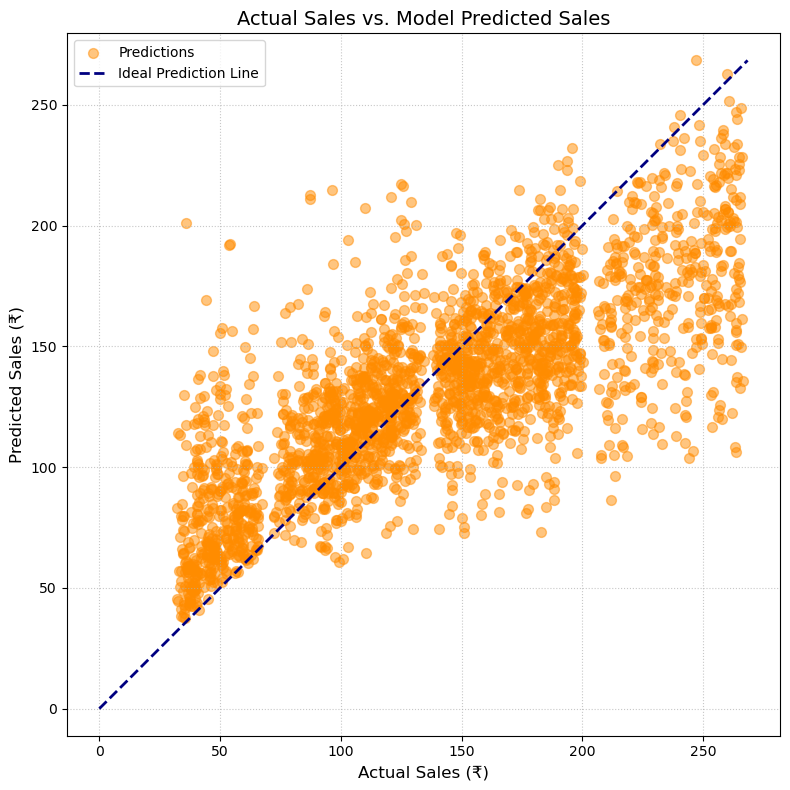

In [15]:
# 1. Convert log-transformed values back to original scale (currency)
actual_sales = np.expm1(y_test)
predicted_sales = np.expm1(predictions)

plt.figure(figsize=(8, 8))
plt.scatter(actual_sales, predicted_sales, 
            alpha=0.5, 
            color='darkorange',
            s=50, # size of points
            label='Predictions')

# 2. Plot the ideal line (where Actual = Predicted)
max_val = max(actual_sales.max(), predicted_sales.max())
plt.plot([0, max_val], [0, max_val], 
         color='navy', 
         linestyle='--', 
         linewidth=2,
         label='Ideal Prediction Line')

plt.title('Actual Sales vs. Model Predicted Sales', fontsize=14)
plt.xlabel('Actual Sales (₹)', fontsize=12)
plt.ylabel('Predicted Sales (₹)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.axis('equal') 
plt.tight_layout()
plt.show()

C:\Users\NNG Mathur\AppData\Local\Temp\ipykernel_10732\1154935020.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


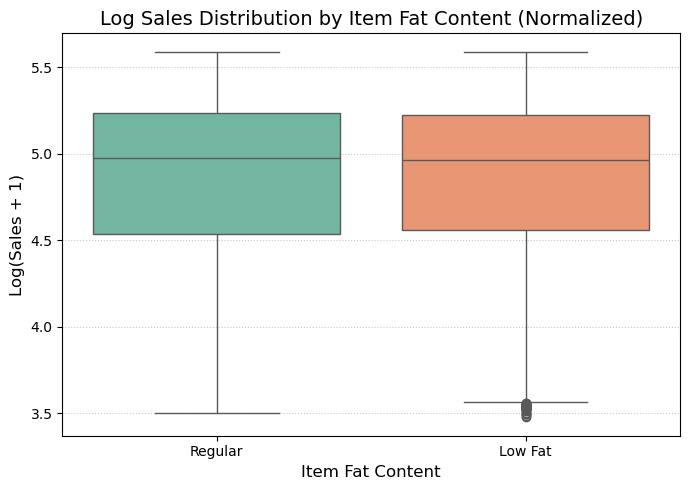

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


temp_df = df_cleaned.copy() 

plt.figure(figsize=(7, 5))
sns.boxplot(
    x='Item Fat Content', 
    y='Sales_Log', 
    data=temp_df,
    palette='Set2' 
)

plt.title('Log Sales Distribution by Item Fat Content (Normalized)', fontsize=14)
plt.xlabel('Item Fat Content', fontsize=12)
plt.ylabel('Log(Sales + 1)', fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# 💡 Pro-Tip for Interpretation in your report:
# You can note that while the medians look similar on the log scale,
# the slight difference supports the model's finding that the category 
# (Regular vs. Low Fat) is still an important driver.